In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from deepviz.guided_backprop import GuidedBackprop
# from sklearn.cross_validation import train_test_split
from sklearn.metrics.ranking import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
from deepviz.guided_backprop import GuidedBackprop

try:
    import keras
    from imblearn.keras import balanced_batch_generator
    from imblearn.under_sampling import NearMiss
    import keras.backend as K
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam
    from keras.optimizers import Adagrad
    from keras.optimizers import SGD
    from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint
    from keras.layers.core import Lambda
    from keras.losses import categorical_crossentropy
    from keras import regularizers

except:
    print("Keras not found")
    
np.random.seed(42)


def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/concept proof'

Using TensorFlow backend.


In [3]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/spec_filtered/taxa.txt",header=None)
taxa.columns=["taxon"] 



In [ ]:
#create text file to store results in and close again:
with open(file_dir+'/results/DNN_eval.txt','w+') as file:
    file.write("Species"+"\t"+"Test_loss"+"\t"+"Test_acc"+"\t"+"Test_tpr"+"\t"+"Test_AUC"+"\t"+"occ_samples"+"\t"+"abs_samples"+"\n")
    file.close()

In [4]:
for species in taxa["taxon"][101:]:
    try:
        print(species)
        spec = species

        #prepare dataframe for training, include weight for presence obserevations
        table = pd.read_csv(file_dir +"/data/spec_occ_env/%s_env_dataframe.csv"%spec)
        # print(len(table.index))
        table = table.dropna(axis=0, how="any")


        # make feature vector
        band_columns = [column for column in table.columns[1:42]]
        X = []
        y = []

        for _, row in table.iterrows():
            x = row[band_columns].values
            x = x.tolist()
            x.append(row["present/pseudo_absent"])
            X.append(x)

        df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
        #df.head()
        df.to_csv("filtered.csv", index=None)

        ###########################################
        occ_len=int(len(df[df["presence" ]==1]))
        #print(occ_len)
        abs_len=int(len(df[df["presence" ]==0]))
        #print(abs_len)
        ############################################

        X = []
        y = []

        band_columns = [column for column in df.columns[:-1]]
        # print(band_columns)

        for _, row in df.iterrows():
            X.append(row[band_columns].values.tolist())
            y.append([1 - row["presence"], row["presence"]])

        X = np.vstack(X)
        #print(X)
        #print(type(X))
        print(X.shape)
        y = np.vstack(y)


        ######################### The actual model#####################
        #########################                 #####################
        #########################                 #####################
        test_loss=[]
        test_acc=[]
        test_AUC=[]
        test_tpr=[]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y,random_state=42)
        ####################
        Best_model_AUC=[0]
        ####################
        for i in range(1,6):
           # print("run %s"%i)

            batch_size = 75
            num_classes = 2
            epochs = 125

            num_inputs = X.shape[1]  # number of features

            #reducelr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8,
             #                                     verbose=1)

            model = Sequential()
            layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))

            layer_2 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
            layer_3 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
            layer_4 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.00000001))


            model.add(layer_1)
            model.add(Dropout(0.3))
            model.add(layer_2)
            model.add(Dropout(0.5))
            model.add(layer_3)
            model.add(Dropout(0.3))
            model.add(layer_4)
            model.add(Dropout(0.5))



            # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
            # model.add(Dense(512, activation='relu',
            #             # kernel_regularizer=regularizers.l2(0.01),
            #             # activity_regularizer=regularizers.l1(0.01)
            #                 ))
            # model.add(Dropout(0.5))
            # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
            out_layer = Dense(num_classes, activation=None)
            model.add(out_layer)
            model.add(Activation("softmax"))

            model.summary()

            model.compile(loss="categorical_crossentropy",
                        # optimizer =SGD(lr=0.001, momentum =0.9, nesterov=True),
                        # optimizer=Adagrad(lr=0.001),
                        # optimizer=RMSprop(lr=0.001),# rho=0.9, epsilon=1e-08, decay=0.0),
                        optimizer=Adam(lr=0.001),#, rho=0.9, epsilon=1e-08, decay=0.0),
                        metrics =['accuracy'])
            training_generator,steps_per_epoch = balanced_batch_generator(X_train, y_train, sampler=NearMiss(), batch_size=75, random_state=42)
            history = model.fit_generator(generator=training_generator, steps_per_epoch=steps_per_epoch, epochs=125, verbose=0)

            #X_train, y_train,
            #batch_size =training_generator,
            #epochs =epochs,
            #verbose =1,
            #validation_data =(X_test, y_test),
            #callbacks =[],
            #shuffle =True,
            #class_weight ={
             #   0: 1,
              #  1: 1,
            #}
            #)

            score = model.evaluate(X_test, y_test, verbose=0)
            #print('Test loss:', score[0])
            #print('Test accuracy:', score[1])
            predictions = model.predict(X_test)
            #print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
            fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
            len_tpr=int(len(tpr)/2)
           # print(len_tpr)
           # print("true positive rate", tpr[len_tpr])
            #plt.plot(fpr, tpr)
            #plt.show()


            test_loss.append(score[0])
            test_acc.append(score[1])
            test_AUC.append(roc_auc_score(y_test[:, 1], predictions[:, 1]))
            test_tpr.append(tpr[len_tpr])
            AUC = roc_auc_score(y_test[:, 1], predictions[:, 1])

            #determine whether new model AUC is higher
            if AUC > Best_model_AUC[0]:
                # if yes save model to disk / overwrite previous model
                Best_model_AUC[0]=AUC
                model_json=model.to_json()
                with open (file_dir+'/results/DNN_model/%s_model.json'%spec,'w') as json_file:
                    json_file.write(model_json)
                model.save_weights(file_dir+'/results/DNN_model/%s_model.h5'%spec)
                #print('saved model to disk')


            #guided_bprop = GuidedBackprop(model)
            #mask = guided_bprop.get_mask(X_test[0])
            #masks = []
            #for i in range(X_test.shape[0]):
             #   masks.append(guided_bprop.get_mask(X_test[i]))
                #print(masks[-1].shape)
            #print(np.vstack(masks).shape)
            #mask = np.mean(np.vstack(masks), axis=0)
            #print(band_columns[mask.argmax()])
            #print(np.array(band_columns)[mask.argsort()])

            #for i, xy in enumerate(zip(fpr, tpr)):
             #   plt.gca().annotate(str(thresholds[i]), xy=xy, textcoords='data')

            #plt.show()

        ####################
        avg_loss= sum(test_loss)/len(test_loss)
        avg_acc = sum(test_acc)/len(test_acc)
        avg_AUC = sum(test_AUC)/len(test_AUC)
        avg_tpr = sum(test_tpr)/len(test_tpr)

        with open(file_dir+'/results/DNN_eval.txt','a') as file:
            file.write(spec+"\t"+str(avg_loss)+"\t"+str(avg_acc)+"\t"+str(avg_tpr)+"\t"+str(avg_AUC)+"\t"+str(occ_len)+"\t"+str(abs_len)+"\n")       

    except:
        pass

Ourebia_ourebi
(1402, 41)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_____________________________________________________________

3288

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                2100      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
__________

3296

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 25)                650       
__________

101

Ovibos_moschatus
(890, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_22 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_23 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 25)          

3297

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_26 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_27 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 25)                650       
__________

3297

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_33 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_34 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_35 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 25)                650       
__________

91

Ovis_ammon
(1016, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_42 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_43 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 25)               

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_45 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_46 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_47 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 25)                650       
__________

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_49 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_50 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_51 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 25)                650       
__________

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_53 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_54 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_55 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 25)                650       
__________

94

Ovis_aries_orientalis
(1006, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_61 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_62 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_63 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 25)    

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_65 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_66 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_67 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_84 (Dense)             (None, 25)                650       
__________

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_69 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_70 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_71 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 25)                650       
__________

3299

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 50)                2100      
_________________________________________________________________
dropout_77 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_78 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_79 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 25)                650       
__________

91

Ovis_canadensis
(1293, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_81 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_82 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_83 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 25)          

3304

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_85 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_86 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_87 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 25)                650       
__________

101

Ovis_dalli
(1053, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_101 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_102 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_103 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 25)               

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_105 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_106 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_107 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_109 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_110 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_111 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_117 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_118 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_119 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 25)                650       
__________

95

Ozotoceros_bezoarticus
(1023, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_121 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_122 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_153 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_123 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 25)   

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_125 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_126 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_127 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_129 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_130 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_131 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_133 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_134 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_135 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_137 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_172 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_138 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_173 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_139 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 25)                650       
__________

91

Pecari_tajacu
(1519, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_141 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_142 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_143 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 25)            

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_145 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_146 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_147 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_184 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_149 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_150 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_188 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_151 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_157 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_158 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_159 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_199 (Dense)            (None, 25)                650       
__________

84

Pelea_capreolus
(1039, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_161 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_202 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_162 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_203 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_163 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 25)          

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_165 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_166 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_208 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_167 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_169 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_212 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_170 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_171 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_214 (Dense)            (None, 25)                650       
__________

86

Phacochoerus_aethiopicus
(1081, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_181 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_227 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_182 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_228 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_183 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 25) 

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_185 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_232 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_186 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_187 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_234 (Dense)            (None, 25)                650       
__________

107

Phacochoerus_africanus
(1628, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_251 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_201 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_252 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_202 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_203 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_254 (Dense)            (None, 25)   

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_205 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_257 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_206 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_258 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_207 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_259 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_209 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_262 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_210 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_263 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_211 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_264 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_217 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_272 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_218 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_273 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_219 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_274 (Dense)            (None, 25)                650       
__________

3308

106

Philantomba_maxwellii
(1247, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_276 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_221 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_277 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_222 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_278 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_223 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_279 (Dense)            (None, 25)    

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_281 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_225 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_282 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_226 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_283 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_227 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_284 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_286 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_229 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_287 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_230 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_288 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_231 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_289 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_237 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_297 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_238 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_298 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_239 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_299 (Dense)            (None, 25)                650       
__________

3308

107

Philantomba_monticola
(1062, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_241 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_302 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_242 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_303 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_243 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_304 (Dense)            (None, 25)    

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_245 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_246 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_308 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_247 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_309 (Dense)            (None, 25)                650       
__________

91

Potamochoerus_larvatus
(1023, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_326 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_261 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_327 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_262 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_328 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_263 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 25)   

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_265 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_332 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_266 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_333 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_267 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_334 (Dense)            (None, 25)                650       
__________

106

Potamochoerus_porcus
(1106, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_281 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_352 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_282 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_353 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_283 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_354 (Dense)            (None, 25)     

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_285 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_357 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_286 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_358 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_287 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_359 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_371 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_297 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_372 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_298 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_373 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_299 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_374 (Dense)            (None, 25)                650       
__________

94

Procapra_picticaudata
(1016, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_376 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_301 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_377 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_302 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_378 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_303 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_379 (Dense)            (None, 25)    

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_381 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_305 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_382 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_306 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_383 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_307 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_384 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_386 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_309 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_387 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_310 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_388 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_311 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_389 (Dense)            (None, 25)                650       
__________

106

Pseudois_nayaur
(1016, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_401 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_321 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_402 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_322 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_403 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_323 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_404 (Dense)            (None, 25)          

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_406 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_325 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_407 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_326 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_408 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_327 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_409 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_421 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_337 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_422 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_338 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_423 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_339 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_424 (Dense)            (None, 25)                650       
__________

99

Pudu_puda
(1094, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_426 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_341 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_427 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_342 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_428 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_343 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_429 (Dense)            (None, 25)                

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_431 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_345 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_432 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_346 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_433 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_347 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_434 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_349 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_437 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_350 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_438 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_351 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_439 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_441 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_353 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_442 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_354 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_443 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_355 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_444 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_446 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_357 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_447 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_358 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_448 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_359 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_449 (Dense)            (None, 25)                650       
__________

95

Rangifer_tarandus
(1042, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_361 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_452 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_362 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_453 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_363 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_454 (Dense)            (None, 25)        

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_456 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_365 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_457 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_366 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_458 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_367 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_459 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_461 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_369 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_462 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_370 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_463 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_371 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_464 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_466 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_373 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_467 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_374 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_468 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_375 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_469 (Dense)            (None, 25)                650       
__________

101

Raphicerus_campestris
(1283, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_476 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_381 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_477 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_382 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_478 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_383 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_479 (Dense)            (None, 25)    

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_481 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_385 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_482 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_386 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_483 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_387 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_484 (Dense)            (None, 25)                650       
__________

3308

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_486 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_389 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_487 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_390 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_488 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_391 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_489 (Dense)            (None, 25)                650       
__________

3310

104

Raphicerus_melanotis
(1020, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_501 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_401 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_502 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_402 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_503 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_403 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_504 (Dense)            (None, 25)     

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_506 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_405 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_507 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_406 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_508 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_407 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_509 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_521 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_417 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_522 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_418 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_523 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_419 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_524 (Dense)            (None, 25)                650       
__________

105

Raphicerus_sharpei
(1035, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_526 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_421 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_527 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_422 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_528 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_423 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_529 (Dense)            (None, 25)       

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_531 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_425 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_532 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_426 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_533 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_427 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_534 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_541 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_433 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_542 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_434 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_543 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_435 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_544 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_546 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_437 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_547 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_438 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_548 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_439 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_549 (Dense)            (None, 25)                650       
__________

87

Redunca_arundinum
(1056, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_551 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_441 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_552 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_442 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_553 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_443 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_554 (Dense)            (None, 25)        

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_556 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_445 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_557 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_446 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_558 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_447 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_559 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_566 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_453 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_567 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_454 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_568 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_455 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_569 (Dense)            (None, 25)                650       
__________

102

Redunca_fulvorufula
(1019, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_576 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_461 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_577 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_462 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_578 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_463 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_579 (Dense)            (None, 25)      

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_581 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_465 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_582 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_466 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_583 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_467 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_584 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_586 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_469 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_587 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_470 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_588 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_471 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_589 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_596 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_477 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_597 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_478 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_598 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_479 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_599 (Dense)            (None, 25)                650       
__________

87

Redunca_redunca
(1509, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_601 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_481 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_602 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_482 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_603 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_483 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_604 (Dense)            (None, 25)          

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_606 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_485 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_607 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_486 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_608 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_487 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_609 (Dense)            (None, 25)                650       
__________

101

Rhinoceros_unicornis
(1013, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_626 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_501 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_627 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_502 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_628 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_503 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_629 (Dense)            (None, 25)     

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_631 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_505 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_632 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_506 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_633 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_507 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_634 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_641 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_513 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_642 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_514 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_643 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_515 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_644 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_646 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_517 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_647 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_518 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_648 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_519 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_649 (Dense)            (None, 25)                650       
__________

3310

76

Rucervus_duvaucelii
(1014, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_651 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_521 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_652 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_522 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_653 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_523 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_654 (Dense)            (None, 25)      

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_656 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_525 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_657 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_526 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_658 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_527 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_659 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_661 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_529 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_662 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_530 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_663 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_531 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_664 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_666 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_533 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_667 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_534 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_668 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_535 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_669 (Dense)            (None, 25)                650       
__________

89

Rupicapra_pyrenaica
(1203, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_676 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_541 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_677 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_542 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_678 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_543 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_679 (Dense)            (None, 25)      

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_681 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_545 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_682 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_546 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_683 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_547 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_684 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_691 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_553 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_692 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_554 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_693 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_555 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_694 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_696 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_557 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_697 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_558 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_698 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_559 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_699 (Dense)            (None, 25)                650       
__________

91

Rupicapra_rupicapra
(1110, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_701 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_561 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_702 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_562 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_703 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_563 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_704 (Dense)            (None, 25)      

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_706 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_565 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_707 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_566 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_708 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_567 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_709 (Dense)            (None, 25)                650       
__________

105

Rusa_timorensis
(1294, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_726 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_581 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_727 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_582 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_728 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_583 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_729 (Dense)            (None, 25)          

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_731 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_585 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_732 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_586 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_733 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_587 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_734 (Dense)            (None, 25)                650       
__________

101

Rusa_unicolor
(1095, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_751 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_601 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_752 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_602 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_753 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_603 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_754 (Dense)            (None, 25)            

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_756 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_605 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_757 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_606 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_758 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_607 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_759 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_761 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_609 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_762 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_610 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_763 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_611 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_764 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_771 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_617 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_772 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_618 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_773 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_619 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_774 (Dense)            (None, 25)                650       
__________

3310

98

Sus_barbatus
(1017, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_776 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_621 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_777 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_622 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_778 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_623 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_779 (Dense)            (None, 25)             

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_781 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_625 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_782 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_626 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_783 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_627 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_784 (Dense)            (None, 25)                650       
__________

97

Sus_cebifrons
(1010, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_801 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_641 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_802 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_642 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_803 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_643 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_804 (Dense)            (None, 25)            

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_806 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_645 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_807 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_646 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_808 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_647 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_809 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_811 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_649 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_812 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_650 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_813 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_651 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_814 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_821 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_657 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_822 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_658 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_823 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_659 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_824 (Dense)            (None, 25)                650       
__________

3310

69

Sus_philippensis
(1008, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_826 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_661 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_827 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_662 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_828 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_663 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_829 (Dense)            (None, 25)         

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_831 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_665 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_832 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_666 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_833 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_667 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_834 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_846 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_677 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_847 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_678 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_848 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_679 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_849 (Dense)            (None, 25)                650       
__________

86

Sus_scrofa
(1083, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_851 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_681 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_852 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_682 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_853 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_683 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_854 (Dense)            (None, 25)               

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_856 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_685 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_857 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_686 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_858 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_687 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_859 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_861 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_689 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_862 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_690 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_863 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_691 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_864 (Dense)            (None, 25)                650       
__________

94

Sylvicapra_grimmia
(1528, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_876 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_701 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_877 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_702 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_878 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_703 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_879 (Dense)            (None, 25)       

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_881 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_705 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_882 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_706 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_883 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_707 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_884 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_891 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_713 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_892 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_714 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_893 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_715 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_894 (Dense)            (None, 25)                650       
__________

3310

91

Syncerus_caffer
(1592, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_901 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_721 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_902 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_722 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_903 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_723 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_904 (Dense)            (None, 25)          

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_906 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_725 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_907 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_726 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_908 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_727 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_909 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_911 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_729 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_912 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_730 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_913 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_731 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_914 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_916 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_733 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_917 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_734 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_918 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_735 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_919 (Dense)            (None, 25)                650       
__________

100

Tapirus_bairdii
(1189, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_926 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_741 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_927 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_742 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_928 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_743 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_929 (Dense)            (None, 25)          

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_931 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_745 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_932 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_746 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_933 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_747 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_934 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_941 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_753 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_942 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_754 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_943 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_755 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_944 (Dense)            (None, 25)                650       
__________

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_946 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_757 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_947 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_758 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_948 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_759 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_949 (Dense)            (None, 25)                650       
__________

99

Tapirus_pinchaque
(1010, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_951 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_761 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_952 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_762 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_953 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_763 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_954 (Dense)            (None, 25)        

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_956 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_765 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_957 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_766 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_958 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_767 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_959 (Dense)            (None, 25)                650       
__________

3310

88

Tapirus_terrestris
(1677, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_976 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_781 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_977 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_782 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_978 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_783 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_979 (Dense)            (None, 25)       

3310

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_981 (Dense)            (None, 50)                2100      
_________________________________________________________________
dropout_785 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_982 (Dense)            (None, 25)                1275      
_________________________________________________________________
dropout_786 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_983 (Dense)            (None, 25)                650       
_________________________________________________________________
dropout_787 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_984 (Dense)            (None, 25)                650       
__________

104

Taurotragus_oryx
(1080, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1001 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_801 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1002 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_802 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1003 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_803 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1004 (Dense)           (None, 25)         

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1006 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_805 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1007 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_806 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1008 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_807 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1009 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1016 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_813 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1017 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_814 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1018 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_815 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1019 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1021 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_817 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1022 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_818 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1023 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_819 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1024 (Dense)           (None, 25)                650       
__________

3315

86

Tayassu_pecari
(1312, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1026 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_821 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1027 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_822 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1028 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_823 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1029 (Dense)           (None, 25)           

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1031 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_825 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1032 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_826 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1033 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_827 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1034 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1046 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_837 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1047 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_838 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1048 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_839 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1049 (Dense)           (None, 25)                650       
__________

99

Tragelaphus_angasii
(1176, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1051 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_841 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1052 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_842 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1053 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_843 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1054 (Dense)           (None, 25)      

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1056 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_845 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1057 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_846 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1058 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_847 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1059 (Dense)           (None, 25)                650       
__________

104

Tragelaphus_buxtoni
(1013, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1076 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_861 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1077 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_862 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1078 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_863 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1079 (Dense)           (None, 25)      

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1081 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_865 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1082 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_866 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1083 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_867 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1084 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1091 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_873 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1092 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_874 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1093 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_875 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1094 (Dense)           (None, 25)                650       
__________

3315

88

Tragelaphus_eurycerus
(1054, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1101 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_881 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1102 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_882 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1103 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_883 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1104 (Dense)           (None, 25)    

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1106 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_885 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1107 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_886 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1108 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_887 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1109 (Dense)           (None, 25)                650       
__________

90

Tragelaphus_imberbis
(1039, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1126 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_901 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1127 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_902 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1128 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_903 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1129 (Dense)           (None, 25)     

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1131 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_905 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1132 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_906 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1133 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_907 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1134 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1136 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_909 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1137 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_910 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1138 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_911 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1139 (Dense)           (None, 25)                650       
__________

105

Tragelaphus_scriptus
(1548, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1151 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_921 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1152 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_922 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1153 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_923 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1154 (Dense)           (None, 25)     

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1156 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_925 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1157 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_926 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1158 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_927 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1159 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1166 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_933 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1167 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_934 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1168 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_935 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1169 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1171 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_937 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1172 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_938 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1173 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_939 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1174 (Dense)           (None, 25)                650       
__________

104

Tragelaphus_spekii
(1035, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1176 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_941 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1177 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_942 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1178 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_943 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1179 (Dense)           (None, 25)       

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1181 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_945 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1182 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_946 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1183 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_947 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1184 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1186 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_949 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1187 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_950 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1188 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_951 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1189 (Dense)           (None, 25)                650       
__________

87

Tragelaphus_strepsiceros
(1535, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1201 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_961 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1202 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_962 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1203 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_963 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1204 (Dense)           (None, 25) 

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1206 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_965 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1207 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_966 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1208 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_967 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1209 (Dense)           (None, 25)                650       
__________

3315

108

Tragulus_javanicus
(1005, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1226 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_981 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1227 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_982 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1228 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_983 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1229 (Dense)           (None, 25)       

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1231 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_985 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1232 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_986 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1233 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_987 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1234 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1236 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_989 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1237 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_990 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1238 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_991 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1239 (Dense)           (None, 25)                650       
__________

3315

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1246 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_997 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_1247 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_998 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1248 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_999 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_1249 (Dense)           (None, 25)                650       
__________

87

Tragulus_kanchil
(1014, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1251 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1001 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1252 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1002 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1253 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1003 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1254 (Dense)           (None, 25)         

3319

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1256 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1005 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1257 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1006 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1258 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1007 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1259 (Dense)           (None, 25)                650       
__________

86

Tragulus_napu
(1011, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1276 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1021 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1277 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1022 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1278 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1023 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1279 (Dense)           (None, 25)            

3319

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1281 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1025 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1282 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1026 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1283 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1027 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1284 (Dense)           (None, 25)                650       
__________

3319

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1296 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1037 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1297 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1038 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1298 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1039 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1299 (Dense)           (None, 25)                650       
__________

3319

82

Vicagna_vicugna
(1009, 41)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1301 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1041 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1302 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1042 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1303 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1043 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1304 (Dense)           (None, 25)          

3319

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1306 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1045 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1307 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1046 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1308 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1047 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1309 (Dense)           (None, 25)                650       
__________

3319

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1311 (Dense)           (None, 50)                2100      
_________________________________________________________________
dropout_1049 (Dropout)       (None, 50)                0         
_________________________________________________________________
dense_1312 (Dense)           (None, 25)                1275      
_________________________________________________________________
dropout_1050 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1313 (Dense)           (None, 25)                650       
_________________________________________________________________
dropout_1051 (Dropout)       (None, 25)                0         
_________________________________________________________________
dense_1314 (Dense)           (None, 25)                650       
__________

72

create graphs for evaluating occurrence sample size on dnn performance

Text(0.5, 0, 'occurrence samples')

Text(0, 0.5, 'Test_loss')

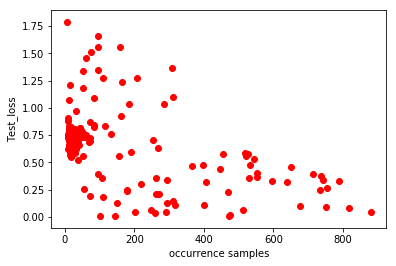

Text(0.5, 0, 'occurrence samples')

Text(0, 0.5, 'Test_acc')

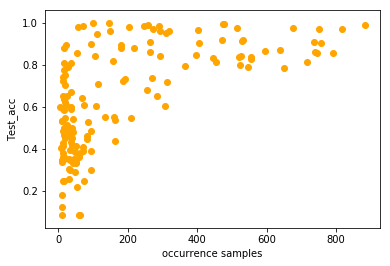

Text(0.5, 0, 'occurrence samples')

Text(0, 0.5, 'Test_AUC')

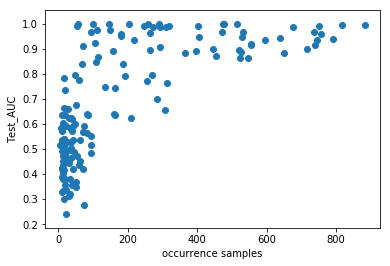

In [3]:
data=pd.read_csv(file_dir+'/results/DNN_eval.txt',sep="\t")
#data
x=data["occ_samples"]
y1=data["Test_loss"]
y2=data["Test_acc"]
#y3=data["Test_tpr"]
y4=data["Test_AUC"]
#n=data["Test_AUC"].round(3)



fig = plt.figure()
plt.scatter(x,y1,c="red")
plt.xlabel("occurrence samples")
plt.ylabel("Test_loss")
fig.savefig(file_dir+'/results/Test_loss.png', dpi=fig.dpi)
plt.show()

fig = plt.figure()
plt.scatter(x,y2,c="orange")
plt.xlabel("occurrence samples")
plt.ylabel("Test_acc")
fig.savefig(file_dir+'/results/Test_acc.png', dpi=fig.dpi)
plt.show()

#fig = plt.figure()
#plt.scatter(x,y3,c="green")
#plt.xlabel("occurrence samples")
#plt.ylabel("Test_tpr")
#fig.savefig(file_dir+'/results/Test_acc.png', dpi=fig.dpi)
#plt.show()


fig = plt.figure()
plt.scatter(x,y4)
plt.xlabel("occurrence samples")
plt.ylabel("Test_AUC")
fig.savefig(file_dir+'/results/Test_AUC.png', dpi=fig.dpi)
plt.show()

#for i, txt in enumerate(n):
 #   plt.annotate(txt, (x[i], y[i]))

In [ ]:
#Backup train code
def main():
    table = pd.read_csv(file_dir +"/data/capriolus_trial/%s_env_dataframe.csv")
    table =table.loc[:1500]
    # at 40 degrees latitude
    bin_size_km = 5
    one_degree_latitude_km = 111.03  # http://www.longitudestore.com/how-big-is-one-gps-degree.html
    one_degree_longitude_km = 85.39
    step_latitude = 1. / one_degree_latitude_km * bin_size_km
    step_longitude = 1. / one_degree_longitude_km * bin_size_km
    # print("step_latitude, step_longitude", step_latitude, step_longitude)

    # remove spaces from column names
    for column in table.columns:
        table[column.strip()] = table[column]
        if column.strip() != column:
            del table[column]
    # print(table.columns)
    # print(table.decimal_latitude.min(), table.decimal_latitude.max())

    latitude_min = table.decimal_latitude.min()
    longitude_min = table.decimal_longitude.min()
    table.decimal_latitude = table.decimal_latitude.apply(lambda x: (x - latitude_min) // step_latitude)
    table.decimal_longitude = table.decimal_longitude.apply(lambda x: (x - longitude_min) // step_longitude)
    table.decimal_latitude = table.decimal_latitude.astype(int)
    table.decimal_longitude = table.decimal_longitude.astype(int)

    # make feature vector
    band_columns = [column for column in table.columns[8:]]
    X = []
    y = []
    for _, row in table.iterrows():
        x = row[band_columns].values
        if (np.any(x <= -9999.0)):  # in sea?
            continue
        # print(row["present/pseudo_absent"], np.where(x <= -9999.0)[0])
        x = x.tolist()
        x.append(row["present/pseudo_absent"])
        X.append(x)

    df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
    df.to_csv("filtered.csv", index=None)

    print(len(df[df["presence" ]==1]))
    print(len(df[df["presence" ]==0]))

    # Scale feature values
    for column in df.columns[:-1]:
        # if "band" in column:
        std_dev = np.std(df[column])
        mean_ = np.mean(df[column])
        df[column] = df[column].apply(lambda x: (x - mean_) / std_dev)
    df.to_csv("normalized.csv", index=None)

    X = []
    y = []
    band_columns = [column for column in df.columns[:-1]]
    # print(band_columns)

    for _, row in df.iterrows():
        X.append(row[band_columns].values.tolist())
        y.append([1 - row["presence"], row["presence"]])

    X = np.vstack(X)
    y = np.vstack(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    batch_size = 75
    num_classes = 2
    epochs = 125
    
    num_inputs = X.shape[1]  # number of features

    #reducelr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8,
     #                                     verbose=1)
    
    model = Sequential()
    layer_1 = Dense(50, activation='relu',input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))

    layer_2 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.000001))
    layer_3 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.0000001))
    layer_4 = Dense(25, activation='relu', input_shape=(num_inputs,))#, kernel_regularizer=regularizers.l1(0.00000001))
    
    
    model.add(layer_1)
    model.add(Dropout(0.3))
    model.add(layer_2)
    model.add(Dropout(0.5))
    model.add(layer_3)
    model.add(Dropout(0.3))
    model.add(layer_4)
    model.add(Dropout(0.5))
  
    
    
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    # model.add(Dense(512, activation='relu',
    #             # kernel_regularizer=regularizers.l2(0.01),
    #             # activity_regularizer=regularizers.l1(0.01)
    #                 ))
    # model.add(Dropout(0.5))
    # model.add(Lambda(lambda x: K.dropout(x, level=0.5)))
    out_layer = Dense(num_classes, activation=None)
    model.add(out_layer)
    model.add(Activation("softmax"))

    model.summary()

    model.compile(loss="categorical_crossentropy",
                # optimizer =SGD(lr=0.001, momentum =0.9, nesterov=True),
                # optimizer=Adagrad(lr=0.001),
                # optimizer=RMSprop(lr=0.001),# rho=0.9, epsilon=1e-08, decay=0.0),
                optimizer=Adam(lr=0.001),#, rho=0.9, epsilon=1e-08, decay=0.0),
                metrics =['accuracy'])

    history = model.fit(X_train, y_train,
    batch_size =batch_size,
    epochs =epochs,
    verbose =1,
    validation_data =(X_test, y_test),
    callbacks =[],
    shuffle =True,
    class_weight ={
        0: 1,
        1: 1,
    }
    )

    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    predictions = model.predict(X_test)
    print("AUC", roc_auc_score(y_test[:, 1], predictions[:, 1]))
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], predictions[:, 1])
    plt.plot(fpr, tpr)
    plt.show()
    
    guided_bprop = GuidedBackprop(model)
    #mask = guided_bprop.get_mask(X_test[0])
    masks = []
    for i in range(X_test.shape[0]):
        masks.append(guided_bprop.get_mask(X_test[i]))
        #print(masks[-1].shape)
    print(np.vstack(masks).shape)
    mask = np.mean(np.vstack(masks), axis=0)
    print(band_columns[mask.argmax()])
    print(np.array(band_columns)[mask.argsort()])
    
    for i, xy in enumerate(zip(fpr, tpr)):
        plt.gca().annotate(str(thresholds[i]), xy=xy, textcoords='data')

    plt.show()


if __name__ == "__main__":
    main()


